# Project 4: Starter

In this project, you will combine and apply your knowledge from all three past unit projects to create a complete data science workflow on a new dataset. We will use the Kaggle Titanic competition dataset for this project.

In [1]:
import numpy as np
import pandas as pd
from sklearn import cross_validation
from sklearn import neighbors
from sklearn import grid_search
from sklearn import metrics
from sklearn import linear_model

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid", font_scale=1)
%matplotlib inline

![](../assets/images/workflow/data-science-workflow-01.png)

## Part 1. Identify the Problem

Using the competition description on [Kaggle](https://www.kaggle.com/c/titanic), write a short paragraph summarizing the problem, your goals and hypothesis.

**NOTE**: This section can be less rigorous for a kaggle competition where the problem, goals, and hypothesis are identified for you.

**Problem**: `*** FILL IN ***`

**Goals**: `*** FILL IN ***`

**Hypothesis**: `*** FILL IN ***`

![](../assets/images/workflow/data-science-workflow-02.png)

## Part 2. Acquire the Data

Kaggle has provided two files for this dataset:  
_train.csv_: Use for building a model (contains target variable "Survived")  
_test.csv_: Use for submission file (fill in for target variable "Survived")

Both files have been downloaded and added to your datasets folder. Read the files into a Pandas DataFrame.

**HINT**: You can further split _train.csv_ to generate your own cross validation set. However, use all of _train.csv_ to train your final model since Kaggle has already separated the test set for you.

In [2]:
# Load data
df = pd.read_csv("../assets/datasets/titanic/train.csv")

# Check head
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


![](../assets/images/workflow/data-science-workflow-03-05.png)

## Part 3. Parse, Mine, and Refine the data

Perform exploratory data analysis and verify the quality of the data.

### Check columns and counts to drop any non-generic or near-empty columns

In [3]:
# Check columns
list(df)

['PassengerId',
 'Survived',
 'Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Cabin',
 'Embarked']

In [4]:
# Check counts
df.count()

PassengerId    891
Survived       891
Pclass         891
Name           891
Sex            891
Age            714
SibSp          891
Parch          891
Ticket         891
Fare           891
Cabin          204
Embarked       889
dtype: int64

### Check for missing values and drop or impute

In [5]:
# Check counts for missing values in each column
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

### Write a function to wrangle the data to address any issues from above checks

In [6]:
def wrangler(df):
    # Drop non-generic columns PassengerId, Name, Ticket, and near-empty column Cabin
    df = df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)

    # Replace missing values for age using median value
    df.loc[(df['Age'].isnull()), 'Age'] = df['Age'].dropna().median()
    
    # Replace missing values for Fare using median value 
    # (there are some missing in Kaggle's test set)
    df.loc[(df['Fare'].isnull()), 'Fare'] = df['Fare'].dropna().median()
    
    # Replace missing values for embarked using mode value
    df.loc[(df['Embarked'].isnull()), 'Embarked'] = df['Embarked'].dropna().mode()
    
    return df

In [7]:
# Apply wrangler() to DF
df = wrangler(df)

# Check data
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


### Perform exploratory data analysis

In [8]:
# Get summary statistics for data
df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.361582,0.523008,0.381594,32.204208
std,0.486592,0.836071,13.019697,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


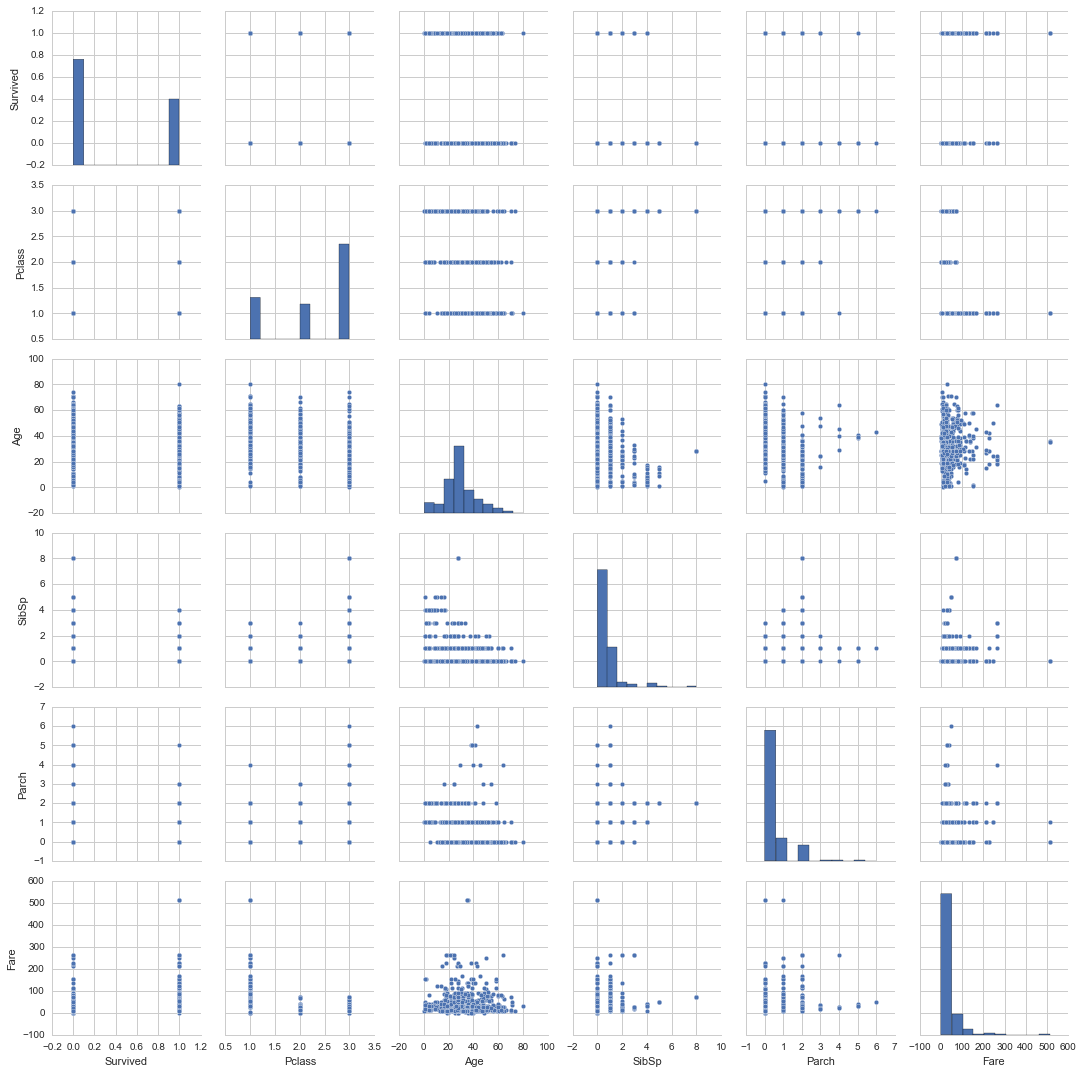

In [9]:
# Get pair plot for data
sns.pairplot(df)

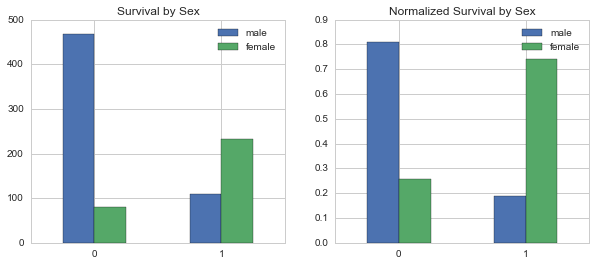

In [10]:
# Analyze Unnormalized and Normalized Survival by Sex

# Get group by counts for Unnormalized Survival by Sex
df_by_sex_unnorm = pd.DataFrame()
df_by_sex_unnorm['male'] = df[df['Sex']=='male']['Survived'].value_counts()
df_by_sex_unnorm['female'] = df[df['Sex']=='female']['Survived'].value_counts()

# Get group by counts for Normalized Survival by Sex
df_by_sex_normed = pd.DataFrame()
df_by_sex_normed['male'] = df[df['Sex']=='male']['Survived'].value_counts(normalize=True)
df_by_sex_normed['female'] = df[df['Sex']=='female']['Survived'].value_counts(normalize=True)

# Plot Unnormalized and Normalized Survival by Sex
fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(121)
df_by_sex_unnorm.plot(ax=ax1, kind='bar', rot=0, title="Survival by Sex")
ax2 = fig.add_subplot(122)
df_by_sex_normed.plot(ax=ax2, kind='bar', rot=0, title="Normalized Survival by Sex")

In [11]:
# What other exploratory analysis can you perform?
# *** FILL IN ***

### Check and convert all data types to numerical

In [12]:
# Check data types
df.dtypes

Survived      int64
Pclass        int64
Sex          object
Age         float64
SibSp         int64
Parch         int64
Fare        float64
Embarked     object
dtype: object

### Write a function to pre-process data for building a model

In [13]:
def pre_proc(df):

    # Create dummy variables for all non-numerical columns

    def dummyfy(cols, df):

        # Get dummy variables for Sex
        for values in cols:
            if values in df.columns:
                # get dummy variables for sex
                df = df.join(pd.get_dummies(df[values], prefix=values))
                # remove sex column
            df.drop([values], axis=1, inplace=True)
            
        return df

    return dummyfy(['Sex', 'Embarked'], df)

In [14]:
# Apply pre_proc() to DF
df = pre_proc(df)

# Check cleaned data
df.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,0.0,1.0,0.0,0.0,1.0
1,1,1,38.0,1,0,71.2833,1.0,0.0,1.0,0.0,0.0
2,1,3,26.0,0,0,7.9250,1.0,0.0,0.0,0.0,1.0
3,1,1,35.0,1,0,53.1000,1.0,0.0,0.0,0.0,1.0
4,0,3,35.0,0,0,8.0500,0.0,1.0,0.0,0.0,1.0


![](../assets/images/workflow/data-science-workflow-06.png)

## Part 4. Build a Model

Create a cross validation split, select and build a model, evaluate the model, and refine the model

### Create cross validation sets

In [15]:
# Set target variable name
target = 'Survived'

# Set X and y
X = df.drop([target], axis=1)
y = df[target]

In [16]:
# Create separate training and test sets with 60/40 train/test split
X_train, X_test, y_train, y_test = \
    cross_validation.train_test_split(X, y, test_size=0.4, random_state=0)

### Build a model

In [17]:
# instantiate lm classifier using default params
lm = linear_model.LogisticRegression()

# train lm classifier on training set
lm.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

### Evaluate the model

In [18]:
# Check model accuracy on test set
print "Accuracy: %0.3f" % lm.score(X_test, y_test)

Accuracy: 0.790


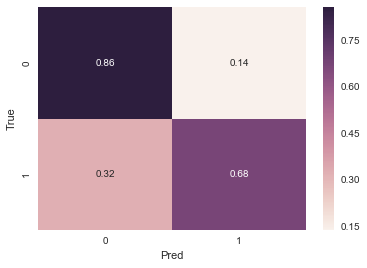

Confusion Matrix:
[[190  31]
 [ 44  92]]


In [19]:
# Get confusion matrix on test set
y_pred = lm.predict(X_test)
cm = metrics.confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

ax = plt.axes()
sns.heatmap(cm_normalized, annot=True)
ax.set_ylabel('True')
ax.set_xlabel('Pred')
plt.show()

print "Confusion Matrix:"
print cm

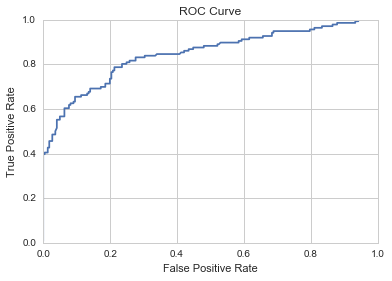

ROC AUC: 0.847


In [20]:
# Plot ROC curve and get AUC score
y_pred_proba = lm.predict_proba(X_test)[:,1]

# Determine the false positive and true positive rates
fpr, tpr, t = metrics.roc_curve(y_test, y_pred_proba)

 
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

# Get ROC AUC score
print 'ROC AUC: %0.3f' % metrics.roc_auc_score(y_test, y_pred_proba)

In [21]:
# What other metrics can you calculate?
# *** FILL IN ***

### Tune the model

In [22]:
# Set list of values to grid search over
c = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
s = ['newton-cg', 'lbfgs', 'liblinear', 'sag']
params = {'C': c, 'solver':s}

# Perform grid search using list of values
gs = grid_search.GridSearchCV(
    estimator=linear_model.LogisticRegression(),
    param_grid=params)
gs.fit(X_train, y_train)

# Get best value to use
print "Best Params:"
print gs.best_estimator_

# Get improvement
print "Accuracy of current model: %0.3f" % lm.score(X_test, y_test)
print "Accuracy using best param: %0.3f" % gs.best_score_

/home/sabbir/anaconda2/envs/venv/lib/python2.7/site-packages/sklearn/linear_model/sag.py:267: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Best Params:
LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Accuracy of current model: 0.790
Accuracy using best param: 0.809


### Update parameters

In [23]:
# Current model params
print lm
print "Accuracy of current model: %0.3f" % lm.score(X_test, y_test)

# Update model params
lm.set_params(C=gs.best_estimator_.C)
lm.set_params(solver=gs.best_estimator_.solver)

# Retrain model on new params
lm.fit(X_train, y_train)

# Updated model params
print lm
print "Accuracy of updated model: %0.3f" % lm.score(X_test, y_test)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Accuracy of current model: 0.790
LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Accuracy of updated model: 0.790


![](../assets/images/workflow/data-science-workflow-07.png)

## Part 5: Present the Results

Generate summary of findings and kaggle submission file.

NOTE: For the purposes of generating summary narratives and kaggle submission, we can train the model on the entire training data provided in _train.csv_.

### Load Kaggle training data and use entire data to train tuned model

In [24]:
# Load data
df_train = pd.read_csv("../assets/datasets/titanic/train.csv")

# Wrangle data
df_train = wrangler(df_train)

# Pre-process data
df_train = pre_proc(df_train)

In [25]:
# Set target variable name
target = 'Survived'

# Set X_train and y_train
X_train = df_train.drop([target], axis=1)
y_train = df_train[target]

In [26]:
# Build tuned model
lm = linear_model.LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='newton-cg', tol=0.0001,
          verbose=0, warm_start=False)

# Train tuned model
lm.fit(X_train, y_train)

# Score tuned model
print "Accuracy: %0.3f" % lm.score(X_train, y_train)

Accuracy: 0.806


### Use trained model to generate a few summary findings

In [27]:
# Generate probabililty of survivial using trained model
df_train['Probability'] = lm.predict_proba(X_train)[:,1]

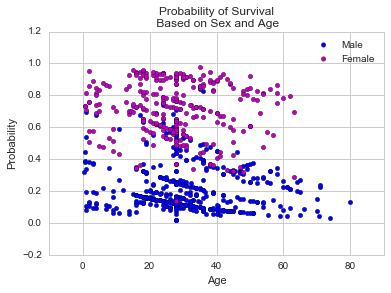

In [28]:
# Plot Probability of Survivial Based on Sex and Age
ax = df_train[df_train['Sex_male']==1].plot(
    x='Age', y='Probability', kind='scatter', color='b', label='Male')
df_train[df_train['Sex_female']==1].plot(
    ax=ax, x='Age', y='Probability', kind='scatter', color='m', label='Female')
ax.set(title='Probability of Survival\n Based on Sex and Age')

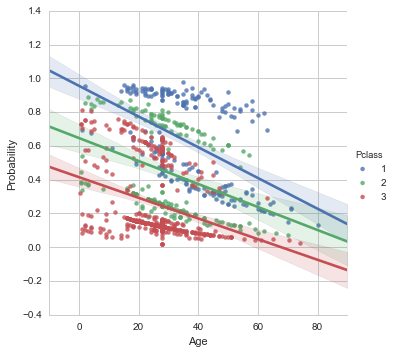

In [29]:
# Plot Probability of Survivial Based on Pclass and Age
sns.lmplot(x="Age", y="Probability", hue="Pclass", data=df_train)

In [30]:
# What other summary visualizations can you make?
# *** FILL IN ***

**Summary of findings**: `*** FILL IN ***`

### Load Kaggle test data, make predictions using model, and generate submission file

In [31]:
# Load data
df_test = pd.read_csv("../assets/datasets/titanic/test.csv")

# Create DF for submission
df_sub = df_test[['PassengerId']]

# Wrangle data
df_test = wrangler(df_test)

# Pre-process data
df_test = pre_proc(df_test)

# Check data
df_sub.head()

# Predict using tuned model
df_sub['Survived'] = lm.predict(df_test)

# Write submission file
df_sub.to_csv("../assets/datasets/titanic/mysubmission.csv", index=False)

print "Check ../assets/datasets/titanic/ for submission file"

Check ../assets/datasets/titanic/ for submission file


**Kaggle score** _(if submitted to Kaggle)_: `*** FILL IN ***`

**HINT**: Try tranforming or combining features and create additional features to improve your score. This is a popular introductory dataset, Google for additional feature engineering hints!